In [26]:
import pandas as pd
from web_scrapping import web_scrape_wikipedia, web_scrape_seattle_children
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drug_data = pd.read_csv("Drug_Data.csv")

In [3]:
diseases = list(drug_data.Prescribed_for.dropna().unique())

In [4]:
diseases_list = []

In [5]:
# cleaning the unnecesary disease type is yet to be processed
disease_list = []
for disease in diseases:
  if "</span>" not in disease:
    disease_list.append(disease)


In [6]:
#  only considering drugs which has medium to high rating
filtered_df = drug_data[(drug_data['Prescribed_for'].isin(disease_list)) & (drug_data['User_Rating']>=5)]

In [7]:
aggregated_df = filtered_df.groupby('Prescribed_for').agg(DrugName_list=('drugName', 'unique')).reset_index(drop=False)

In [8]:
diseases_final = list(aggregated_df['Prescribed_for'])

### Web scraping to retrive symptoms from wikipedia

In [9]:
disease_with_symptoms = web_scrape_wikipedia(diseases_final)

In [10]:
print("Number of diseases retrived from wikipedia is {}".format(len(disease_with_symptoms.keys())))

Number of diseases retrived from wikipedia is 498


In [11]:
# extracting diseases that's not been retrieved from wikipedia

unretrived_diseases = [key for key in diseases_final if key not in disease_with_symptoms.keys()]

In [12]:
print("Number of diseases unretrived from wikipedia is {}".format(len(unretrived_diseases)))

Number of diseases unretrived from wikipedia is 136


### Web scraping to retrive remaining disease's symptoms from seattlechildren's

In [13]:
base_url = 'https://www.seattlechildrens.org'

unretrived_diseases_symptoms = web_scrape_seattle_children(base_url, unretrived_diseases)

In [14]:
final_disease_symptoms = {**disease_with_symptoms, **unretrived_diseases_symptoms}

In [15]:
print("Final number of diseases available with symptoms {}".format(len(final_disease_symptoms.keys())))

Final number of diseases available with symptoms 500


### creating final dataframe with all the disease's and symptoms with drug list

In [16]:
prescribed_for, symptoms = [], []
for key, value in final_disease_symptoms.items():
    prescribed_for.append(key)
    symptoms.append(value)


In [17]:
symptoms_df = pd.DataFrame({'Prescribed_for': prescribed_for, 'Symptoms': symptoms}, index=range(1, len(final_disease_symptoms) + 1))

In [18]:
final_df = aggregated_df.merge(symptoms_df,on='Prescribed_for', how='left')

In [19]:
final_df.head(5)

,Prescribed_for,DrugName_list,Symptoms
0,ADHD,"[Clonidine, Bupropion, Vyvanse, Dexmethylpheni...",Inattention carelessness hyperactivity executi...
1,AIDS Related Wasting,[Serostim],Early : Flu-like illness Later : Large lymph n...
2,Abnormal Uterine Bleeding,"[Ethinyl estradiol / levonorgestrel, Mirena, L...","Irregular, abnormally frequent, prolonged, or ..."
3,Abortion,[Misoprostol],NaN
4,Acetaminophen Overdose,[Mucomyst-10],"Early : Non specific, feeling tired, abdominal..."


## Inserting Length column which depicts the length of Symptoms


In [20]:
final_df['Symptoms'] = final_df['Symptoms'].astype(str)
final_df['Symptoms_Length'] = final_df['Symptoms'].apply(len)
final_df

,Prescribed_for,DrugName_list,Symptoms,Symptoms_Length
0,ADHD,"[Clonidine, Bupropion, Vyvanse, Dexmethylpheni...",Inattention carelessness hyperactivity executi...,134
1,AIDS Related Wasting,[Serostim],Early : Flu-like illness Later : Large lymph n...,71
2,Abnormal Uterine Bleeding,"[Ethinyl estradiol / levonorgestrel, Mirena, L...","Irregular, abnormally frequent, prolonged, or ...",83
3,Abortion,[Misoprostol],nan,3
4,Acetaminophen Overdose,[Mucomyst-10],"Early : Non specific, feeling tired, abdominal...",121
...,...,...,...,...
629,moterol),"[Budesonide / formoterol, Formoterol, Arformot...",nan,3
630,mulation) (phenylephrine),[Phenylephrine],nan,3
631,tic (mycophenolic acid),[Mycophenolic acid],nan,3
632,von Willebrand's Disease,[Desmopressin],Easy and prolonged bleeding,27


## Co-ocurences of diseases - Which Diseases come together

In [21]:
from itertools import combinations
from collections import Counter


# Tokenizing the diseases
diseases_tokenized = final_df['Prescribed_for'].str.split(', ')

# co-occurrences of diseases- counting
disease_pairs = Counter()
for diseases in diseases_tokenized:
    disease_pairs.update(combinations(diseases, 2))

# Most common diseases occuring together
print("Diseases that are occuring together are : \n")
for pair, count in disease_pairs.most_common(20):
    print(pair, "-", count)


Diseases that are occuring together are : 

('Anemia', 'Chemotherapy Induced') - 1
('Anemia', 'Sickle Cell') - 1
('Aspergillosis', 'Aspergilloma') - 1
('Asthma', 'Maintenance') - 1
('Asthma', 'acute') - 1
('Breast Cancer', 'Adjuvant') - 1
('Breast Cancer', 'Metastatic') - 1
('Breast Cancer', 'Palliative') - 1
('Breast Cancer', 'Prevention') - 1
('Burns', 'External') - 1
('COPD', 'Acute') - 1
('COPD', 'Maintenance') - 1
('Conjunctivitis', 'Allergic') - 1
('Conjunctivitis', 'Bacterial') - 1
('Constipation', 'Acute') - 1
('Constipation', 'Chronic') - 1
('Constipation', 'Drug Induced') - 1
("Crohn's Disease", 'Acute') - 1
("Crohn's Disease", 'Maintenance') - 1
('Deep Vein Thrombosis', 'First Event') - 1


## Co-ocurences of Symptoms - Which Symptoms come together

In [22]:
# Tokenizing the symptoms
symptoms_tokenized = final_df['Symptoms'].str.split(', ')

# Countig the co-occurrences of symptoms
symptom_pairs = Counter()
for symptoms in symptoms_tokenized:
  symptom_pairs.update(combinations(symptoms,3))


# Most common symptoms occuring together
print("Symptoms that are occuring together are : \n")
symptom_cooccuring={}
for pair, count in symptom_pairs.most_common(30):
  symptom_cooccuring[pair]=count
  print(pair, "-", count)


Symptoms that are occuring together are : 

('Abdominal pain ', 'fever ', 'fatigue ') - 8
('Abdominal pain ', 'weight loss ', 'fatigue ') - 8
('Infrequent or hard to pass bowel movements ', 'abdominal pain', 'bloating') - 5
('Pain', 'swelling ', 'redness') - 5
('Pain', 'swelling ', 'enlarged veins in the affected limb') - 5
('Pain', 'redness', 'enlarged veins in the affected limb') - 5
('swelling ', 'redness', 'enlarged veins in the affected limb') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'weight loss ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'fever ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'anemia ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'dehydration ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'loss of appetite') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'fatigue ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'sores on the skin') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'urgency 

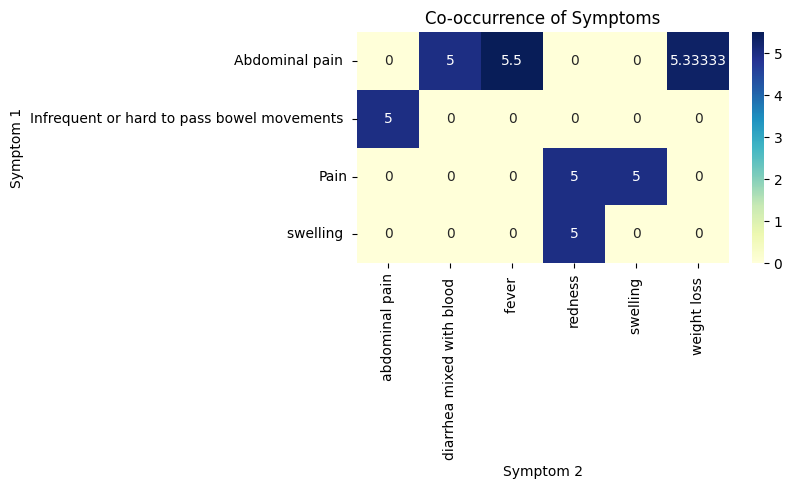

In [27]:
df = pd.DataFrame(symptom_cooccuring.items(), columns=['Symptom Pair', 'Count'])
df = df.groupby('Symptom Pair')['Count'].sum().reset_index()
df[['Symptom 1', 'Symptom 2', 'Symptom 3']] = pd.DataFrame(df['Symptom Pair'].tolist(), index=df.index)
pivot_table = df.pivot_table(index='Symptom 1', columns='Symptom 2', values='Count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Co-occurrence of Symptoms')
plt.xlabel('Symptom 2')
plt.ylabel('Symptom 1')
plt.show()


## No of Drugs for each disease:

In [30]:
final_df['Number_of_Drugs'] = final_df['DrugName_list'].apply(lambda x: len(x))

In [31]:
final_df.head()

,Prescribed_for,DrugName_list,Symptoms,Symptoms_Length,Number_of_Drugs
0,ADHD,"[Clonidine, Bupropion, Vyvanse, Dexmethylpheni...",Inattention carelessness hyperactivity executi...,134,46
1,AIDS Related Wasting,[Serostim],Early : Flu-like illness Later : Large lymph n...,71,1
2,Abnormal Uterine Bleeding,"[Ethinyl estradiol / levonorgestrel, Mirena, L...","Irregular, abnormally frequent, prolonged, or ...",83,38
3,Abortion,[Misoprostol],nan,3,1
4,Acetaminophen Overdose,[Mucomyst-10],"Early : Non specific, feeling tired, abdominal...",121,1


## Word Cloud Plot

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

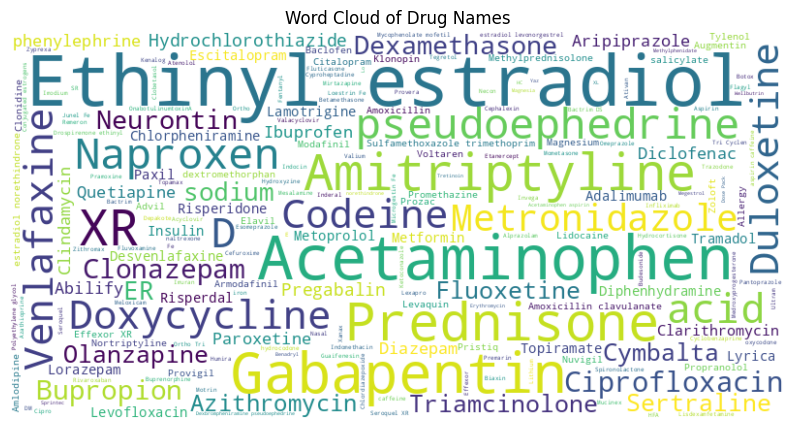

In [36]:
# Joining all drug names into a single string
all_drugs = ' '.join(final_df['DrugName_list'].explode().dropna())

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_drugs)

# word cloud plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Drug Names')
plt.axis('off')
plt.show()

In [41]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

In [43]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [46]:
# Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return None
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stem the words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Preprocessing the symptoms
final_df['Preprocessed_Symptoms'] = final_df['Symptoms'].apply(preprocess_text)


In [47]:
final_df.head()

,Prescribed_for,DrugName_list,Symptoms,Symptoms_Length,Number_of_Drugs,Preprocessed_Symptoms
0,ADHD,"[Clonidine, Bupropion, Vyvanse, Dexmethylpheni...",Inattention carelessness hyperactivity executi...,134,46,inattent careless hyperact execut dysfunct dis...
1,AIDS Related Wasting,[Serostim],Early : Flu-like illness Later : Large lymph n...,71,1,earli flulik ill later larg lymph node fever w...
2,Abnormal Uterine Bleeding,"[Ethinyl estradiol / levonorgestrel, Mirena, L...","Irregular, abnormally frequent, prolonged, or ...",83,38,irregular abnorm frequent prolong excess amoun...
3,Abortion,[Misoprostol],nan,3,1,nan
4,Acetaminophen Overdose,[Mucomyst-10],"Early : Non specific, feeling tired, abdominal...",121,1,earli non specif feel tire abdomin pain nausea...


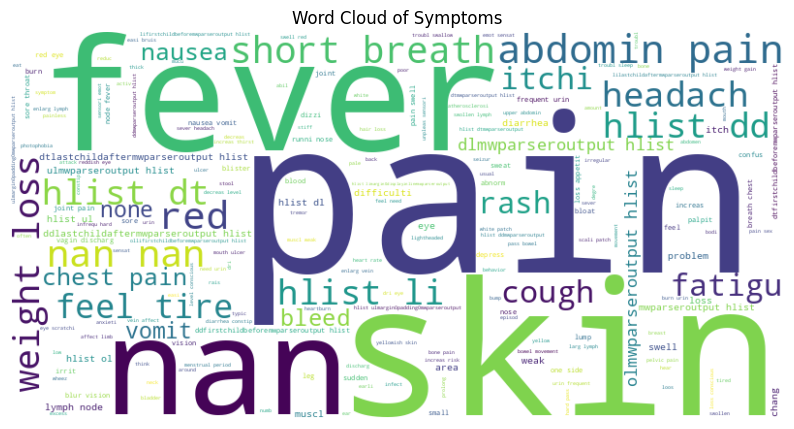

In [49]:
# Word cloud generation
all_preprocessed_symptoms = ' '.join(final_df['Preprocessed_Symptoms'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_preprocessed_symptoms)

# Word cloud Plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Symptoms')
plt.axis('off')
plt.show()
